# Supervised Machine Learning Techniques for Anomaly Detection


In this report, we will use H2O module in Python to build (1) the GBM (Gradient Boosting Machine) model and (2) the Deep Learning with the mortgage probability of default data. The criteria for the models include ROC and the cumulative Lift. For each kind of model, we will use grid search to find out the hyper-parameters for models and also select or drop the variables to improve the model performance.



# Table of Contents <a class="anchor" id="0"></a>
- <b>[1. Data Preparation](#1)</b>
- <b>[2. H2O Introduction](#2)</b>
- <b>[3. Sample Model & Metrics Functions](#3)</b>
- <b>[4. GBM (Gradient Boosting Machine) Model](#4)</b>
- <b>[5. Deep Learning](#5)</b>
- <b>[6. Conclusion](#6)</b>

       
  <p>&nbsp;</p>

In [ ]:
# !pip install h2o
# !pip install numpy
# !pip install pandas
# !pip install matplotlib
# !pip install sklearn

In [7]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import h2o
import math

## 1. Data Preparation <a class="anchor" id="1"></a>

In [8]:
# load data
path = r'C:/Users/ZTQ/Desktop/' 
data = pd.read_csv(path + 'XYZloan_default_selected_vars.csv')  
#data = pd.read_csv('XYZloan_default_selected_vars.csv') 
data.tail()

,Unnamed: 0,Unnamed: 0.1,id,loan_default,AP001,AP002,AP003,AP004,AP005,AP006,...,CD162,CD164,CD166,CD167,CD169,CD170,CD172,CD173,MB005,MB007
79995,79995,79996,79996,0,39,2,1,12,2017/5/7 13:44,android,...,15.0,8.0,864.0,684.0,1261.0,764.0,2600.0,1074.0,11.0,OPPO
79996,79996,79997,79997,0,31,1,4,12,2017/6/2 15:54,ios,...,25.0,25.0,6177.0,6177.0,6426.0,6426.0,6426.0,6426.0,6.0,IPHONE7
79997,79997,79998,79998,0,37,1,1,12,2017/7/9 8:40,android,...,14.0,13.0,1116.0,1116.0,2061.0,2061.0,2501.0,2061.0,12.0,VIVO
79998,79998,79999,79999,0,38,2,1,12,2017/5/9 10:19,android,...,5.0,2.0,25.0,0.0,498.0,343.0,514.0,343.0,6.0,XIAOMI
79999,79999,80000,80000,1,25,1,3,12,2017/4/27 18:36,h5,...,9.0,9.0,129.0,129.0,167.0,167.0,167.0,167.0,7.0,WEB


In [9]:
# split the data for modeling
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.20, random_state=42) 

In [10]:
train.shape

(64000, 89)

In [11]:
var = pd.DataFrame(train.dtypes).reset_index()
var.head()

,index,0
0,Unnamed: 0,int64
1,Unnamed: 0.1,int64
2,id,int64
3,loan_default,int64
4,AP001,int64


In [12]:
# change the colum names of var dataframe
var.columns = ['varname','dtype'] 
var.head(10)

,varname,dtype
0,Unnamed: 0,int64
1,Unnamed: 0.1,int64
2,id,int64
3,loan_default,int64
4,AP001,int64
5,AP002,int64
6,AP003,int64
7,AP004,int64
8,AP005,object
9,AP006,object


In [13]:
var['source'] = var['varname'].str[:2]
var.head()

,varname,dtype,source
0,Unnamed: 0,int64,Un
1,Unnamed: 0.1,int64,Un
2,id,int64,id
3,loan_default,int64,lo
4,AP001,int64,AP


In [14]:
var['source'].value_counts()

CD    36
TD    24
AP     9
CR     8
PA     6
MB     2
Un     2
id     1
lo     1
Name: source, dtype: int64

In [15]:
# "AP004" is a bad data field and should be removed.
MB_list = list(var[var['source']=='MB']['varname'])
AP_list = list(var[(var['source']=='AP') & (var['varname']!='AP004')]['varname'])
TD_list = list(var[var['source']=='TD']['varname'])
CR_list = list(var[var['source']=='CR']['varname'])
PA_list = list(var[var['source']=='PA']['varname'])
CD_list = list(var[var['source']=='CD']['varname'])
AP_list

['AP001', 'AP002', 'AP003', 'AP005', 'AP006', 'AP007', 'AP008', 'AP009']

In [16]:
train['loan_default'].value_counts(dropna=False)

0    51662
1    12338
Name: loan_default, dtype: int64

In [17]:
target='loan_default'
predictors = CR_list + TD_list + AP_list + MB_list + CR_list + PA_list 

## 2. H2O Introduction <a class="anchor" id="2"></a>

In [18]:
h2o.init(port=8888)
# h2o.init(nthreads=-1, strict_version_check=True)

Checking whether there is an H2O instance running at http://localhost:8888 ..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM (build 18.0.2+9-61, mixed mode, sharing)
  Starting server from C:\ProgramData\Anaconda3\envs\gpu2\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\ZTQ\AppData\Local\Temp\tmphzfg07lz
  JVM stdout: C:\Users\ZTQ\AppData\Local\Temp\tmphzfg07lz\h2o_ZTQ_started_from_python.out
  JVM stderr: C:\Users\ZTQ\AppData\Local\Temp\tmphzfg07lz\h2o_ZTQ_started_from_python.err
  Server is running at http://127.0.0.1:8890
Connecting to H2O server at http://127.0.0.1:8890 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.1
H2O_cluster_version_age:,29 days
H2O_cluster_name:,H2O_from_python_ZTQ_lx0evg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.979 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


## 3. Sample Model & Metrics Functions <a class="anchor" id="3"></a>

In [19]:
train_smpl = train.sample(frac=0.1, random_state=1)
test_smpl = test.sample(frac=0.1, random_state=1)
train_hex = h2o.H2OFrame(train_smpl)
test_hex = h2o.H2OFrame(test_smpl)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [20]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
# Build and train the model:
gbm_v1 = H2OGradientBoostingEstimator(nfolds=5,
                                        seed=1111,
                                        keep_cross_validation_predictions = True)
gbm_v1.train(x=predictors, y=target, training_frame=train_hex)
gbm_v1.train(predictors,target,training_frame=train_hex)

gbm Model Build progress: |

C:\ProgramData\Anaconda3\envs\gpu2\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [TD054, TD051, TD062, CR012, TD048, AP005, TD044, TD055]
  warnings.warn(mesg["message"], RuntimeWarning)
C:\ProgramData\Anaconda3\envs\gpu2\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_model_python_1666117181107_2


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    50                 50                          19907                  5            5            5             14            32            24.52

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.11729715715031527
RMSE: 0.34248672550963966
MAE: 0.2574703333878915
RMSLE: 0.23809549962075632
Mean Residual Deviance: 0.11729715715031527

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 0.14974899998965863
RMSE: 0.386974159330644
MAE: 0.29161135855580456
RMSLE: 0.27218780487186883
Mean Residual Deviance: 0.14974899998965863

Cross-Validation Metrics Summary: 
                        mean       sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  ---------  ----------  ------------  ------------  ------------  ------------  ------------
mae                     0.291691   0.00338432  0.289275      0.294215      0.28735       0.292104      0.29551
mean_residual_deviance  0.149845   0.00354289  0.146084      0.152786      0.14689       0.14933       0.154136
mse                     0.149845   0.00354289  0.146084      0.152786      0.14689       0.14933       0.154136
r2                      0.0236069  0.0184093   0.0222406     0.017372      0.0487877     -0.00140436   0.0310386
residual_deviance       0.149845   0.00354289  0.146084      0.152786      0.14689       0.14933       0.154136
rmse                    0.387077   0.00457274  0.382209      0.390878      0.383262      0.386433      0.392602
rmsle                   0.272228   0.00284889  0.270275      0.274336      0.2682        0.273682      0.274649

Scoring History: 
     timestamp            duration    number_of_trees    training_rmse        training_mae         training_deviance
---  -------------------  ----------  -----------------  -------------------  -------------------  -------------------
     2022-10-18 14:19:48  0.805 sec   0.0                0.39168228789216053  0.30683002929687747  0.15341501464843732
     2022-10-18 14:19:48  0.813 sec   1.0                0.38881417366859145  0.3044736587186344   0.1511764616455896
     2022-10-18 14:19:48  0.818 sec   2.0                0.3865441766733692   0.3024822064326145   0.14941640052009286
     2022-10-18 14:19:48  0.824 sec   3.0                0.38396264711257755  0.30019924632506445  0.14742731437769774
     2022-10-18 14:19:48  0.830 sec   4.0                0.382096854819467    0.2983950267639011   0.14599800646292882
     2022-10-18 14:19:48  0.836 sec   5.0                0.3800699151012467   0.2964135157619603   0.14445314036506887
     2022-10-18 14:19:48  0.840 sec   6.0                0.3781942969958738   0.29460710709448906  0.1430309262802032
     2022-10-18 14:19:48  0.845 sec   7.0                0.37689411054496746  0.29329655511770397  0.14204917056348215
     2022-10-18 14:19:48  0.849 sec   8.0                0.37550339267635735  0.2918395955150481   0.14100279791145462
     2022-10-18 14:19:48  0.854 sec   9.0                0.3739888209805933   0.29020808162284084  0.13986763821845424
---  ---                  ---         ---                ---                  ---                  ---
     2022-10-18 14:19:48  0.959 sec   41.0               0.34680602329079174  0.26167232884061375  0.12027441779077319
     2022-10-18 14:19:48  0.962 sec   42.0               0.346227202731835    0.26101626161151215  0.11987327591151117
     2022-10-18 14:19:48  0.965 sec   43.0               0.345492548738973    0.26035312230099406  0.11936510123415164
     2022-10-18 14:1

In [21]:
predictions = gbm_v1.predict(test_hex)
test_scores = test_hex['loan_default'].cbind(predictions).as_data_frame()
test_scores.head()

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


C:\ProgramData\Anaconda3\envs\gpu2\lib\site-packages\h2o\job.py:83: UserWarning: Test/Validation dataset column 'MB007' has levels not trained on: ["MOTOROLA"]
  warnings.warn(w)


,loan_default,predict
0,0,0.311790
1,0,0.232343
2,0,0.269055
3,0,0.116890
4,0,0.174470


Here we define functions to generate gains table and ROC/AUC. We will first use a portion of dataset to validate that our self defined functions are application. We will then apply the functions to the whole dataset. 

### Gains Table
A Gains Chart can serve two great purposes to help our business strategies: (i) selecting the better-performing model, and (ii) deciding which segments to target. In this case, we will use it to select the better-performing model to detect the loan faults.

In [22]:
# define a function to conduct gains table
def createGains(model):
    predictions = model.predict(test_hex)
    test_scores = test_hex['loan_default'].cbind(predictions).as_data_frame()

    #sort on prediction (descending), add id, and decile for groups containing 1/10 of datapoints
    test_scores = test_scores.sort_values(by='predict',ascending=False)
    test_scores['row_id'] = range(0,0+len(test_scores))
    test_scores['decile'] = ( test_scores['row_id'] / (len(test_scores)/10) ).astype(int)
    #see count by decile
    test_scores.loc[test_scores['decile'] == 10]=9
    test_scores['decile'].value_counts()

    #create gains table
    gains = test_scores.groupby('decile')['loan_default'].agg(['count','sum'])
    gains.columns = ['count','actual']
    gains

    #add features to gains table
    gains['non_actual'] = gains['count'] - gains['actual']
    gains['cum_count'] = gains['count'].cumsum()
    gains['cum_actual'] = gains['actual'].cumsum()
    gains['cum_non_actual'] = gains['non_actual'].cumsum()
    gains['percent_cum_actual'] = (gains['cum_actual'] / np.max(gains['cum_actual'])).round(2)
    gains['percent_cum_non_actual'] = (gains['cum_non_actual'] / np.max(gains['cum_non_actual'])).round(2)
    gains['if_random'] = np.max(gains['cum_actual']) /10 
    gains['if_random'] = gains['if_random'].cumsum()
    gains['lift'] = (gains['cum_actual'] / gains['if_random']).round(2)
    gains['K_S'] = np.abs( gains['percent_cum_actual'] -  gains['percent_cum_non_actual'] ) * 100
    gains['gain']=(gains['cum_actual']/gains['cum_count']*100).round(2)
    gains = pd.DataFrame(gains)
    return(gains)

createGains(gbm_v1)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


C:\ProgramData\Anaconda3\envs\gpu2\lib\site-packages\h2o\job.py:83: UserWarning: Test/Validation dataset column 'MB007' has levels not trained on: ["MOTOROLA"]
  warnings.warn(w)


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,160,57,103,160,57,103,0.19,0.08,30.0,1.90,11.0,35.62
1,160,34,126,320,91,229,0.30,0.18,60.0,1.52,12.0,28.44
2,160,44,116,480,135,345,0.45,0.27,90.0,1.50,18.0,28.12
3,160,33,127,640,168,472,0.56,0.36,120.0,1.40,20.0,26.25
4,160,31,129,800,199,601,0.66,0.46,150.0,1.33,20.0,24.88
5,160,26,134,960,225,735,0.75,0.57,180.0,1.25,18.0,23.44
6,160,17,143,1120,242,878,0.81,0.68,210.0,1.15,13.0,21.61
7,160,25,135,1280,267,1013,0.89,0.78,240.0,1.11,11.0,20.86
8,160,18,142,1440,285,1155,0.95,0.89,270.0,1.06,6.0,19.79


### ROC (Receiver Operating Characteristic) & AUC (Area Under the Curve)
The receiver operating characteristic (ROC) curve is one of the most effective evaluation metrics because it visualizes the accuracy of predictions for a whole range of cutoff values.If we had a perfect model, the ROC curve would pass through the upper left corner — indicating no error. A better model is when the ROC is close to the upper left corner.  
The most important parameter that can be obtained from a ROC curve is the Area Under the Curve (AUC). For a perfect model, the area under the curve would be 1.0.

In [23]:
# define a functiont to calculate ROC_AUC
def ROC_AUC(my_result,df,target):
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt

    # ROC
    y_actual = df[target].as_data_frame()
    y_pred = my_result.predict(df)['p1'].as_data_frame()
    fpr = list()
    tpr = list()
    roc_auc = list()
    fpr,tpr,_ = roc_curve(y_actual,y_pred)
    roc_auc = auc(fpr,tpr)
    
    # Precision-Recall
    average_precision = average_precision_score(y_actual,y_pred)

    print('')
    print('   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate')
    print('')
    print('	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy')
    print('')
    print('   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)')
    print('')
    
    # plotting
    plt.figure(figsize=(10,4))

    # ROC
    plt.subplot(1,2,1)
    plt.plot(fpr,tpr,color='darkorange',lw=2,label='ROC curve (aare=%0.2f)' % roc_auc)
    plt.plot([0,1],[0,1],color='navy',lw=3,linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: AUC={0:0.4f}'.format(roc_auc))
    plt.legend(loc='lower right')

    # Precision-Recall
    plt.subplot(1,2,2)
    precision,recall,_ = precision_recall_curve(y_actual,y_pred)
    plt.step(recall,precision,color='b',alpha=0.2,where='post')
    plt.fill_between(recall,precision,step='post',alpha=0.2,color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0,1.05])
    plt.xlim([0.0,1.0])
    plt.title('Precision-Recall curve: PR={0:0.4f}'.format(average_precision))
    plt.show()

In [ ]:
# ROC_AUC(gbm_v1,test_hex,'loan_default')

#### [Back to the top](#0)

## 4. GBM (Gradient Boosting Machine) Model
<a class="anchor" id="4"></a>
Gradient Boosting Machine (for Regression and Classification) is a forward learning ensemble method. The guiding heuristic is that good predictive results can be obtained through increasingly refined approximations. 

In [25]:
train_hex = h2o.H2OFrame(train)
test_hex = h2o.H2OFrame(test)

# convert target variable into factor for binary classification
train_hex[target] = train_hex[target].asfactor()
test_hex[target] = test_hex[target].asfactor()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [26]:
from h2o.estimators import H2OGradientBoostingEstimator
# Build and train the model
gbm_v2 = H2OGradientBoostingEstimator(nfolds=5,
                                      seed=1234,
                                      keep_cross_validation_predictions = True)
gbm_v2.train(x=predictors, y=target, training_frame=train_hex)

gbm Model Build progress: |

C:\ProgramData\Anaconda3\envs\gpu2\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [CR012]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_model_python_1666117181107_3


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    50                 50                          27645                  5            5            5             25            32            30.36

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.14055400071679183
RMSE: 0.37490532233724266
LogLoss: 0.44487085780534064
Mean Per-Class Error: 0.34600052780194845
AUC: 0.7160857345630872
AUCPR: 0.3999271164481561
Gini: 0.43217146912617443

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2099491895246
       0      1      Error    Rate
-----  -----  -----  -------  -----------------
0      36446  15216  0.2945   (15216.0/51662.0)
1      4904   7434   0.3975   (4904.0/12338.0)
Total  41350  22650  0.3144   (20120.0/64000.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.209949     0.424946  223
max f2                       0.141574     0.581708  301
max f0point5                 0.300642     0.410507  142
max accuracy                 0.408605     0.814438  75
max precision                0.885235     1         0
max recall                   0.044232     1         398
max specificity              0.885235     1         0
max absolute_mcc             0.238882     0.258108  194
max min_per_class_accuracy   0.197621     0.654887  236
max mean_per_class_accuracy  0.193504     0.657796  241
max tns                      0.885235     51662     0
max fns                      0.885235     12337     0
max fps                      0.0399588    51662     399
max tps                      0.044232     12338     398
max tnr                      0.885235     1         0
max fnr                      0.885235     0.999919  0
max fpr                      0.0399588    1         399
max tpr                      0.044232     1         398

Gains/Lift Table: Avg response rate: 19.28 %, avg score: 19.29 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.01                        0.475753           3.95526   3.95526            0.7625           0.544999   0.7625                      0.544999            0.0395526       0.0395526                  295.526   295.526            0.0366104
2        0.02                        0.43048            2.99887   3.47706            0.578125         0.451204   0.670312                    0.498101            0.0299887       0.0695413                  199.887   247.706            0.0613728
3        0.03                        0.403113           2.63414   3.19609            0.507812         0.41617    0.616146                    0.470791            0.0263414       0.0958826                  163.414   219.609            0.0816168
4        0.04                        0.383884           2.36667   2.98873            0.45625          0.393166   0.576172                    0.451385            0.0236667       0.119549                   136.667   198.873            0.0985475
5        0.05                        0.368431           2.4153    2.87405            0.465625         0.375784   0.554063    

In [27]:
createGains(gbm_v2)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


C:\ProgramData\Anaconda3\envs\gpu2\lib\site-packages\h2o\job.py:83: UserWarning: Test/Validation dataset column 'AP005' has levels not trained on: ["2017/3/22 15:12", "2017/3/28 17:20", "2017/3/28 18:58", "2017/3/28 20:20", "2017/3/28 22:38", "2017/3/29 11:14", "2017/3/29 14:05", "2017/3/29 15:33", "2017/3/29 18:33", "2017/3/29 19:01", ...7908 not listed..., "2017/7/9 4:43", "2017/7/9 5:59", "2017/7/9 6:34", "2017/7/9 7:35", "2017/7/9 8:16", "2017/7/9 8:20", "2017/7/9 8:31", "2017/7/9 8:32", "2017/7/9 8:37", "2017/7/9 9:46"]
  warnings.warn(w)
C:\ProgramData\Anaconda3\envs\gpu2\lib\site-packages\h2o\job.py:83: UserWarning: Test/Validation dataset column 'MB007' has levels not trained on: ["EYU", "HONGLAJIAO", "IPAD3", "KINGSUN", "MANN", "PHILIPS", "PROTRULY", "REDGOO", "VOLTE"]
  warnings.warn(w)


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,1600,473,1127,1600,473,1127,0.15,0.09,315.0,1.50,6.0,29.56
1,1600,483,1117,3200,956,2244,0.30,0.17,630.0,1.52,13.0,29.88
2,1600,487,1113,4800,1443,3357,0.46,0.26,945.0,1.53,20.0,30.06
3,1600,376,1224,6400,1819,4581,0.58,0.36,1260.0,1.44,22.0,28.42
4,1600,217,1383,8000,2036,5964,0.65,0.46,1575.0,1.29,19.0,25.45
5,1600,208,1392,9600,2244,7356,0.71,0.57,1890.0,1.19,14.0,23.38
6,1600,225,1375,11200,2469,8731,0.78,0.68,2205.0,1.12,10.0,22.04
7,1600,249,1351,12800,2718,10082,0.86,0.78,2520.0,1.08,8.0,21.23
8,1600,224,1376,14400,2942,11458,0.93,0.89,2835.0,1.04,4.0,20.43


gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



C:\ProgramData\Anaconda3\envs\gpu2\lib\site-packages\h2o\job.py:83: UserWarning: Test/Validation dataset column 'AP005' has levels not trained on: ["2017/3/22 15:12", "2017/3/28 17:20", "2017/3/28 18:58", "2017/3/28 20:20", "2017/3/28 22:38", "2017/3/29 11:14", "2017/3/29 14:05", "2017/3/29 15:33", "2017/3/29 18:33", "2017/3/29 19:01", ...7908 not listed..., "2017/7/9 4:43", "2017/7/9 5:59", "2017/7/9 6:34", "2017/7/9 7:35", "2017/7/9 8:16", "2017/7/9 8:20", "2017/7/9 8:31", "2017/7/9 8:32", "2017/7/9 8:37", "2017/7/9 9:46"]
  warnings.warn(w)
C:\ProgramData\Anaconda3\envs\gpu2\lib\site-packages\h2o\job.py:83: UserWarning: Test/Validation dataset column 'MB007' has levels not trained on: ["EYU", "HONGLAJIAO", "IPAD3", "KINGSUN", "MANN", "PHILIPS", "PROTRULY", "REDGOO", "VOLTE"]
  warnings.warn(w)


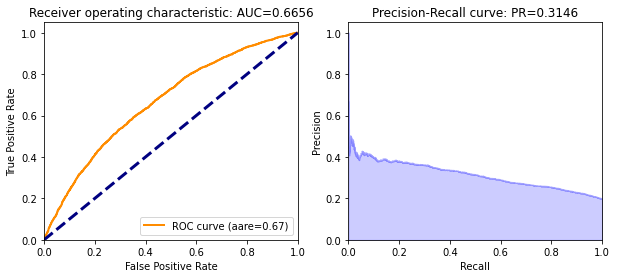

In [28]:
ROC_AUC(gbm_v2,test_hex,'loan_default')

The orange curve is the ROC curve. The above plot with 0.6656 AUC means that the model result is slightly better than a completely random draw(blue line). We will use this model as a basic model for the following model improvement.

### Hyper-parameter Tunning
Here we will use grid search to find the optimized hyper-parameter.
 - We want to know what value of max_depth and ntree to use because it has a big impact on the model training time and optimal values depend strongly on the dataset. 
 - We'll do a quick Cartesian grid search to get a rough idea of good candidate max_depth values. Each model in the grid search will use early stopping to tune the number of trees using the validation set AUC, as before. We'll use learning rate annealing to speed up convergence without sacrificing too much accuracy.

In [29]:
#GBM hyperparameters
gbm_params = {"ntrees" : [100,200,300], 
              "max_depth": [4, 6, 8, 10, 12], 
              'learn_rate':[0.01, 0.02, 0.03]}
search_criteria_tune = {"strategy": "RandomDiscrete", 
                        "max_models": 20, 
                        "seed": 12345}

In [30]:
from h2o.grid.grid_search import H2OGridSearch

#Build initial GBM Model
gbm_model=H2OGradientBoostingEstimator(nfolds=5,
                                       fold_assignment="Modulo",
                                       keep_cross_validation_predictions=True,
                                       seed=1234)
#Build grid search with previously made GBM and hyper parameters
gbm_grid1 = H2OGridSearch(gbm_model, 
                          grid_id='gbm_grid1',
                          hyper_params=gbm_params,
                          search_criteria=search_criteria_tune)

In [31]:
#Train grid search
gbm_grid1.train(x=predictors, y=target, training_frame=train_hex)

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


,learn_rate,max_depth,ntrees,model_ids,logloss
,0.03,4.0,300.0,gbm_grid1_model_6,0.4635613
,0.02,6.0,200.0,gbm_grid1_model_11,0.4642438
,0.03,6.0,200.0,gbm_grid1_model_10,0.4642496
,0.02,6.0,300.0,gbm_grid1_model_5,0.4642506
,0.03,6.0,100.0,gbm_grid1_model_8,0.4647146
,0.03,6.0,300.0,gbm_grid1_model_7,0.4648958
,0.02,8.0,200.0,gbm_grid1_model_3,0.4658792
,0.01,8.0,200.0,gbm_grid1_model_17,0.4666084
,0.01,10.0,300.0,gbm_grid1_model_12,0.4682038
,0.02,4.0,100.0,gbm_grid1_model_1,0.4684505


In [32]:
# sort the grid models by decreasing AUC
gbm_grid_sorted = gbm_grid1.get_grid(sort_by='auc',decreasing=True)
print(gbm_grid_sorted)

Hyper-Parameter Search Summary: ordered by decreasing auc
    learn_rate    max_depth    ntrees    model_ids           auc
--  ------------  -----------  --------  ------------------  --------
    0.03          4            300       gbm_grid1_model_6   0.665769
    0.02          6            300       gbm_grid1_model_5   0.664519
    0.03          6            200       gbm_grid1_model_10  0.664499
    0.02          6            200       gbm_grid1_model_11  0.664263
    0.03          6            300       gbm_grid1_model_7   0.663477
    0.03          6            100       gbm_grid1_model_8   0.663436
    0.02          8            200       gbm_grid1_model_3   0.6612
    0.01          8            200       gbm_grid1_model_17  0.659355
    0.02          4            100       gbm_grid1_model_1   0.657637
    0.01          4            200       gbm_grid1_model_2   0.657507
    0.01          10           300       gbm_grid1_model_12  0.655024
    0.01          8            100     

It appears that learn rate of 0.03, max_depth values of 4 and 300 trees are best suited for this dataset.

In [33]:
# Grab the top GBM model, chosen by validation AUC
best_gbm = gbm_grid_sorted.models[0]
best_gbm

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: gbm_grid1_model_6


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    300                300                         90171                  4            4            4             8             16            15.1433

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.1416268722025872
RMSE: 0.37633345878700075
LogLoss: 0.44751417735033866
Mean Per-Class Error: 0.3480236394350979
AUC: 0.7083449455075207
AUCPR: 0.3824741215361561
Gini: 0.4166898910150414

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1927544510878211
       0      1      Error    Rate
-----  -----  -----  -------  -----------------
0      32816  18846  0.3648   (18846.0/51662.0)
1      4087   8251   0.3313   (4087.0/12338.0)
Total  36903  27097  0.3583   (22933.0/64000.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.192754     0.418461  240
max f2                       0.13483      0.579306  307
max f0point5                 0.288469     0.390665  149
max accuracy                 0.429982     0.812406  67
max precision                0.883951     1         0
max recall                   0.0419891    1         397
max specificity              0.883951     1         0
max absolute_mcc             0.239473     0.24482   191
max min_per_class_accuracy   0.196132     0.648891  236
max mean_per_class_accuracy  0.186159     0.652007  247
max tns                      0.883951     51662     0
max fns                      0.883951     12336     0
max fps                      0.03448      51662     399
max tps                      0.0419891    12338     397
max tnr                      0.883951     1         0
max fnr                      0.883951     0.999838  0
max fpr                      0.03448      1         399
max tpr                      0.0419891    1         397

Gains/Lift Table: Avg response rate: 19.28 %, avg score: 19.28 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.01                        0.474752           3.61485   3.61485            0.696875         0.539866   0.696875                    0.539866            0.0361485       0.0361485                  261.485   261.485            0.0323933
2        0.02                        0.432483           2.92592   3.27038            0.564063         0.451667   0.630469                    0.495767            0.0292592       0.0654077                  192.592   227.038            0.056252
3        0.03                        0.406462           2.52067   3.02048            0.485938         0.418855   0.582292                    0.47013             0.0252067       0.0906144                  152.067   202.048            0.0750904
4        0.04                        0.387564           2.35046   2.85297            0.453125         0.396165   0.55                        0.451638            0.0235046       0.114119                   135.046   185.297            0.0918202
5        0.05                        0.3724             2.13973   2.71033            0.4125           0.379753   0.5225                    

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



C:\ProgramData\Anaconda3\envs\gpu2\lib\site-packages\h2o\job.py:83: UserWarning: Test/Validation dataset column 'AP005' has levels not trained on: ["2017/3/22 15:12", "2017/3/28 17:20", "2017/3/28 18:58", "2017/3/28 20:20", "2017/3/28 22:38", "2017/3/29 11:14", "2017/3/29 14:05", "2017/3/29 15:33", "2017/3/29 18:33", "2017/3/29 19:01", ...7908 not listed..., "2017/7/9 4:43", "2017/7/9 5:59", "2017/7/9 6:34", "2017/7/9 7:35", "2017/7/9 8:16", "2017/7/9 8:20", "2017/7/9 8:31", "2017/7/9 8:32", "2017/7/9 8:37", "2017/7/9 9:46"]
  warnings.warn(w)
C:\ProgramData\Anaconda3\envs\gpu2\lib\site-packages\h2o\job.py:83: UserWarning: Test/Validation dataset column 'MB007' has levels not trained on: ["EYU", "HONGLAJIAO", "IPAD3", "KINGSUN", "MANN", "PHILIPS", "PROTRULY", "REDGOO", "VOLTE"]
  warnings.warn(w)


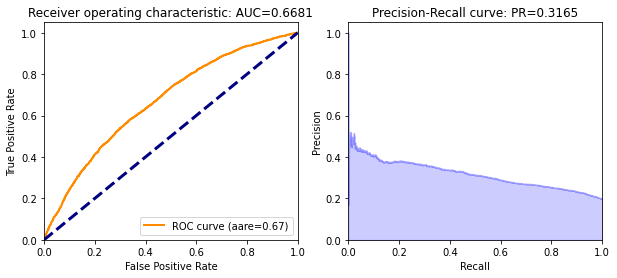

In [34]:
# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
ROC_AUC(best_gbm,test_hex,'loan_default')

In [35]:
createGains(best_gbm)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


C:\ProgramData\Anaconda3\envs\gpu2\lib\site-packages\h2o\job.py:83: UserWarning: Test/Validation dataset column 'AP005' has levels not trained on: ["2017/3/22 15:12", "2017/3/28 17:20", "2017/3/28 18:58", "2017/3/28 20:20", "2017/3/28 22:38", "2017/3/29 11:14", "2017/3/29 14:05", "2017/3/29 15:33", "2017/3/29 18:33", "2017/3/29 19:01", ...7908 not listed..., "2017/7/9 4:43", "2017/7/9 5:59", "2017/7/9 6:34", "2017/7/9 7:35", "2017/7/9 8:16", "2017/7/9 8:20", "2017/7/9 8:31", "2017/7/9 8:32", "2017/7/9 8:37", "2017/7/9 9:46"]
  warnings.warn(w)
C:\ProgramData\Anaconda3\envs\gpu2\lib\site-packages\h2o\job.py:83: UserWarning: Test/Validation dataset column 'MB007' has levels not trained on: ["EYU", "HONGLAJIAO", "IPAD3", "KINGSUN", "MANN", "PHILIPS", "PROTRULY", "REDGOO", "VOLTE"]
  warnings.warn(w)


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,1600,449,1151,1600,449,1151,0.14,0.09,315.0,1.43,5.0,28.06
1,1600,468,1132,3200,917,2283,0.29,0.18,630.0,1.46,11.0,28.66
2,1600,451,1149,4800,1368,3432,0.43,0.27,945.0,1.45,16.0,28.50
3,1600,434,1166,6400,1802,4598,0.57,0.36,1260.0,1.43,21.0,28.16
4,1600,293,1307,8000,2095,5905,0.67,0.46,1575.0,1.33,21.0,26.19
5,1600,197,1403,9600,2292,7308,0.73,0.57,1890.0,1.21,16.0,23.88
6,1600,208,1392,11200,2500,8700,0.79,0.68,2205.0,1.13,11.0,22.32
7,1600,240,1360,12800,2740,10060,0.87,0.78,2520.0,1.09,9.0,21.41
8,1600,222,1378,14400,2962,11438,0.94,0.89,2835.0,1.04,5.0,20.57


According to the graph above, we were able to get the AUC on a holdout test set from 66.56% range with the default model to 66.81% range after tuning.

### Featrue Selection with Variable importance

In [36]:
# Retrieve the variable importance
varimp = best_gbm.varimp(use_pandas=True)

In [37]:
# select the features that has variable importances higher than 0
feature_selected = varimp[varimp['relative_importance']>0]['variable'].tolist()
predictors_selected = feature_selected
feature_selected.append('loan_default')

In [38]:
train_selected = train_hex[feature_selected]
test_selected = test_hex[feature_selected]

In [39]:
from h2o.estimators import H2OGradientBoostingEstimator
# Build and train the model
gbm_v3 = H2OGradientBoostingEstimator(ntrees = 300,
                                      max_depth = 4, 
                                      nfolds=5,
                                      seed=1234,
                                      keep_cross_validation_predictions = True)
gbm_v3.train(x=predictors_selected, y=target, training_frame=train_selected)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_model_python_1666117181107_12584


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    300                300                         88550                  4            4            4             7             16            14.3

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.13181472860455543
RMSE: 0.36306298159486794
LogLoss: 0.4210021049264463
Mean Per-Class Error: 0.3163035179745067
AUC: 0.759396470683895
AUCPR: 0.4946769830747042
Gini: 0.5187929413677901

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23022142625323677
       0      1      Error    Rate
-----  -----  -----  -------  -----------------
0      40109  11553  0.2236   (11553.0/51662.0)
1      5046   7292   0.409    (5046.0/12338.0)
Total  45155  18845  0.2594   (16599.0/64000.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.230221     0.467691  218
max f2                       0.150297     0.601458  287
max f0point5                 0.344346     0.488413  137
max accuracy                 0.397302     0.829625  110
max precision                0.962233     1         0
max recall                   0.0299894    1         394
max specificity              0.962233     1         0
max absolute_mcc             0.285258     0.329279  175
max min_per_class_accuracy   0.200342     0.687488  241
max mean_per_class_accuracy  0.204012     0.689525  238
max tns                      0.962233     51662     0
max fns                      0.962233     12334     0
max fps                      0.00599317   51662     399
max tps                      0.0299894    12338     394
max tnr                      0.962233     1         0
max fnr                      0.962233     0.999676  0
max fpr                      0.00599317   1         399
max tpr                      0.0299894    1         394

Gains/Lift Table: Avg response rate: 19.28 %, avg score: 19.28 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.01                        0.568333           4.9846    4.9846             0.960938         0.682917   0.960938                    0.682917            0.049846        0.049846                   398.46    398.46             0.0493621
2        0.02                        0.495678           4.14978   4.56719            0.8              0.528242   0.880469                    0.60558             0.0414978       0.0913438                  314.978   356.719            0.0883823
3        0.03                        0.453911           3.59053   4.24164            0.692187         0.473196   0.817708                    0.561452            0.0359053       0.127249                   259.053   324.164            0.120474
4        0.04                        0.42423            3.07992   3.95121            0.59375          0.43848    0.761719                    0.530709            0.0307992       0.158048                   207.992   295.121            0.146241
5        0.05                        0.402853           2.95024   3.75101            0.56875          0.413096   0.723125  

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



C:\ProgramData\Anaconda3\envs\gpu2\lib\site-packages\h2o\job.py:83: UserWarning: Test/Validation dataset column 'MB007' has levels not trained on: ["EYU", "HONGLAJIAO", "IPAD3", "KINGSUN", "MANN", "PHILIPS", "PROTRULY", "REDGOO", "VOLTE"]
  warnings.warn(w)
C:\ProgramData\Anaconda3\envs\gpu2\lib\site-packages\h2o\job.py:83: UserWarning: Test/Validation dataset column 'AP005' has levels not trained on: ["2017/3/22 15:12", "2017/3/28 17:20", "2017/3/28 18:58", "2017/3/28 20:20", "2017/3/28 22:38", "2017/3/29 11:14", "2017/3/29 14:05", "2017/3/29 15:33", "2017/3/29 18:33", "2017/3/29 19:01", ...7908 not listed..., "2017/7/9 4:43", "2017/7/9 5:59", "2017/7/9 6:34", "2017/7/9 7:35", "2017/7/9 8:16", "2017/7/9 8:20", "2017/7/9 8:31", "2017/7/9 8:32", "2017/7/9 8:37", "2017/7/9 9:46"]
  warnings.warn(w)


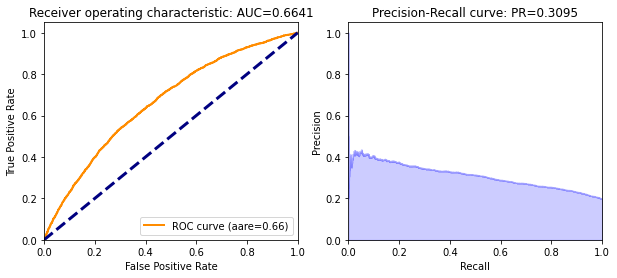

In [40]:
ROC_AUC(gbm_v3,test_selected,'loan_default')

In [41]:
createGains(gbm_v3)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


C:\ProgramData\Anaconda3\envs\gpu2\lib\site-packages\h2o\job.py:83: UserWarning: Test/Validation dataset column 'MB007' has levels not trained on: ["EYU", "HONGLAJIAO", "IPAD3", "KINGSUN", "MANN", "PHILIPS", "PROTRULY", "REDGOO", "VOLTE"]
  warnings.warn(w)
C:\ProgramData\Anaconda3\envs\gpu2\lib\site-packages\h2o\job.py:83: UserWarning: Test/Validation dataset column 'AP005' has levels not trained on: ["2017/3/22 15:12", "2017/3/28 17:20", "2017/3/28 18:58", "2017/3/28 20:20", "2017/3/28 22:38", "2017/3/29 11:14", "2017/3/29 14:05", "2017/3/29 15:33", "2017/3/29 18:33", "2017/3/29 19:01", ...7908 not listed..., "2017/7/9 4:43", "2017/7/9 5:59", "2017/7/9 6:34", "2017/7/9 7:35", "2017/7/9 8:16", "2017/7/9 8:20", "2017/7/9 8:31", "2017/7/9 8:32", "2017/7/9 8:37", "2017/7/9 9:46"]
  warnings.warn(w)


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,1600,475,1125,1600,475,1125,0.15,0.09,315.0,1.51,6.0,29.69
1,1600,536,1064,3200,1011,2189,0.32,0.17,630.0,1.60,15.0,31.59
2,1600,494,1106,4800,1505,3295,0.48,0.26,945.0,1.59,22.0,31.35
3,1600,250,1350,6400,1755,4645,0.56,0.36,1260.0,1.39,20.0,27.42
4,1600,223,1377,8000,1978,6022,0.63,0.47,1575.0,1.26,16.0,24.72
5,1600,217,1383,9600,2195,7405,0.70,0.58,1890.0,1.16,12.0,22.86
6,1600,247,1353,11200,2442,8758,0.78,0.68,2205.0,1.11,10.0,21.80
7,1600,246,1354,12800,2688,10112,0.85,0.79,2520.0,1.07,6.0,21.00
8,1600,227,1373,14400,2915,11485,0.93,0.89,2835.0,1.03,4.0,20.24


The AUC is 0.6641 and the highest lift is 1.61, smaller than the best model before, which means that the model with the selected variables does not perform well as expected. The reason may be that the model is over-fitting with less features.

#### [Back to the top](#0)

## 5. Deep Learning Model
<a class="anchor" id="5"></a>
Deep learning is a class of machine learning algorithms that uses multiple layers to model patterns in data. It is also called Artificial Neural Network (ANN) or Neural Network (NN). 

### 5.1 data preparation

In [42]:
data[var[var['dtype']=='object']['varname']]

,AP005,AP006,MB007
0,2017/7/6 10:21,ios,IPHONE7
1,2017/4/6 12:51,h5,WEB
2,2017/7/1 14:11,h5,WEB
3,2017/7/7 10:10,android,OPPO
4,2017/7/6 14:37,h5,WEB
...,...,...,...
79995,2017/5/7 13:44,android,OPPO
79996,2017/6/2 15:54,ios,IPHONE7
79997,2017/7/9 8:40,android,VIVO
79998,2017/5/9 10:19,android,XIAOMI


In [43]:
if any(x in var[var['dtype']=='object']['varname'] for x in feature_selected):
    print("Duplicates found.")
else:
    print("No duplicates found.")

No duplicates found.


In [44]:
data.AP005.head()

0    2017/7/6 10:21
1    2017/4/6 12:51
2    2017/7/1 14:11
3    2017/7/7 10:10
4    2017/7/6 14:37
Name: AP005, dtype: object

It appears that 'AP005' is datetime data. We will extract the useful information from this datetime variable for model building.

In [45]:
data['AP005'] = pd.to_datetime(data['AP005'])

In [46]:
data.AP005.head()

0   2017-07-06 10:21:00
1   2017-04-06 12:51:00
2   2017-07-01 14:11:00
3   2017-07-07 10:10:00
4   2017-07-06 14:37:00
Name: AP005, dtype: datetime64[ns]

In [47]:
data['AP005_year'] = data['AP005'].dt.year
data['AP005_month'] = data['AP005'].dt.month
data['AP005_week'] = data['AP005'].dt.week
data['AP005_day'] = data['AP005'].dt.day
data['AP005_hour'] = data['AP005'].dt.hour
data['AP005_minute'] = data['AP005'].dt.minute
data['AP005_dayofweek'] = data['AP005'].dt.dayofweek

C:\ProgramData\Anaconda3\envs\gpu2\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [48]:
data.head()

,Unnamed: 0,Unnamed: 0.1,id,loan_default,AP001,AP002,AP003,AP004,AP005,AP006,...,CD173,MB005,MB007,AP005_year,AP005_month,AP005_week,AP005_day,AP005_hour,AP005_minute,AP005_dayofweek
0,0,1,1,1,31,2,1,12,2017-07-06 10:21:00,ios,...,2249.0,7.0,IPHONE7,2017,7,27,6,10,21,3
1,1,2,2,0,27,1,1,12,2017-04-06 12:51:00,h5,...,-99.0,NaN,WEB,2017,4,14,6,12,51,3
2,2,3,3,0,33,1,4,12,2017-07-01 14:11:00,h5,...,110.0,8.0,WEB,2017,7,26,1,14,11,5
3,3,4,4,0,34,2,4,12,2017-07-07 10:10:00,android,...,0.0,10.0,OPPO,2017,7,27,7,10,10,4
4,4,5,5,0,47,2,1,12,2017-07-06 14:37:00,h5,...,-99.0,NaN,WEB,2017,7,27,6,14,37,3


In [49]:
AP005_new = ['AP005_year', 
             'AP005_month', 
             'AP005_week', 
             'AP005_day', 
             'AP005_hour', 
             'AP005_minute', 
             'AP005_dayofweek']

In [50]:
predictors_new = predictors + AP005_new
predictors_new.remove('AP005')
predictors_new.remove('AP006')
predictors_new.remove('MB007')

In [51]:
# split the data for modeling
from sklearn.model_selection import train_test_split
train_dl, test_dl = train_test_split(data, test_size=0.20, random_state=1)
train_dl, valid_dl = train_test_split(train_dl, test_size=0.25, random_state=1) 

In [52]:
train_dl = h2o.H2OFrame(train_dl)
valid_dl = h2o.H2OFrame(valid_dl)
test_dl = h2o.H2OFrame(test_dl)

# convert target variable into factor for binary classification
train_dl[target] = train_dl[target].asfactor()
valid_dl[target] = valid_dl[target].asfactor()
test_dl[target] = test_dl[target].asfactor()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


### 5.2 Deep Learning Model
First we will train a basic DL model with default parameters. DL will infer the response distribution from the response encoding if not specified explicitly through the distribution argument.

In [53]:
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
# Initialize and train the DL estimator:
dl_fit1 = H2ODeepLearningEstimator(model_id='dl_fit1', seed=1)
dl_fit1.train(x=predictors_new, y=target, training_frame=train_dl)

deeplearning Model Build progress: |

C:\ProgramData\Anaconda3\envs\gpu2\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [CR012, AP005_year, TD029, TD028, TD027, TD026, TD025]
  warnings.warn(mesg["message"], RuntimeWarning)


█████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: dl_fit1


Status of Neuron Layers: predicting loan_default, 2-class classification, bernoulli distribution, CrossEntropy loss, 52,602 weights/biases, 629.7 KB, 480,000 training samples, mini-batch size 1
    layer    units    type       dropout    l1    l2    mean_rate             rate_rms               momentum    mean_weight            weight_rms           mean_bias               bias_rms
--  -------  -------  ---------  ---------  ----  ----  --------------------  ---------------------  ----------  ---------------------  -------------------  ----------------------  -------------------
    1        59       Input      0.0
    2        200      Rectifier  0.0        0.0   0.0   0.1551240787858546    0.35544633865356445    0.0         -0.01619365247544307   0.13275539875030518  0.3733876278426193      0.06533187627792358
    3        200      Rectifier  0.0        0.0   0.0   0.08272104479564514   0.09697127342224121    0.0         -0.030945638970853707  0.08442839980125427  0.6765690702785488      0.18409103155136108
    4        2        Softmax               0.0   0.0   0.004974623155285371  0.0018306360580027103  0.0         0.01015720323775895    0.36337947845458984  -0.0020492478843266576  0.221815824508667

ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.13721078448292767
RMSE: 0.3704197409465749
LogLoss: 0.435481440846747
Mean Per-Class Error: 0.32904829727376306
AUC: 0.7278004444455424
AUCPR: 0.41168446619799026
Gini: 0.45560088889108474

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2439282378047856
       0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      5837  2229  0.2763   (2229.0/8066.0)
1      728   1179  0.3818   (728.0/1907.0)
Total  6565  3408  0.2965   (2957.0/9973.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.243928     0.44365   207
max f2                       0.13632      0.585567  298
max f0point5                 0.33234      0.419526  142
max accuracy                 0.500867     0.818009  61
max precision                0.856546     1         0
max recall                   0.00654092   1         398
max specificity              0.856546     1         0
max absolute_mcc             0.243928     0.283492  207
max min_per_class_accuracy   0.224032     0.668609  223
max mean_per_class_accuracy  0.243928     0.670952  207
max tns                      0.856546     8066      0
max fns                      0.856546     1906      0
max fps                      0.00194291   8066      399
max tps                      0.00654092   1907      398
max tnr                      0.856546     1         0
max fnr                      0.856546     0.999476  0
max fpr                      0.00194291   1         399
max tpr                      0.00654092   1         398

Gains/Lift Table: Avg response rate: 19.12 %, avg score: 20.89 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100271                   0.589816           3.81767   3.81767            0.73             0.652295   0.73                        0.652295            0.03828         0.03828                    281.767   281.767            0.0349326
2        0.0200541                   0.529253           3.39929   3.60848            0.65             0.559462   0.69                        0.605878     

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



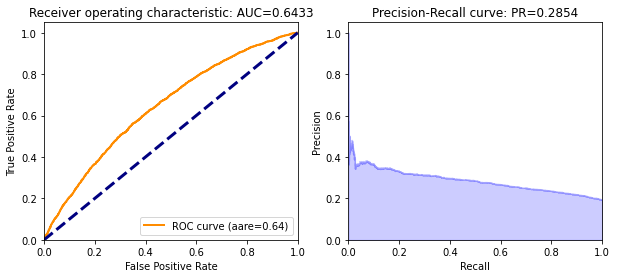

In [54]:
ROC_AUC(dl_fit1,test_dl,'loan_default')

In [55]:
createGains(dl_fit1)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


C:\ProgramData\Anaconda3\envs\gpu2\lib\site-packages\h2o\job.py:83: UserWarning: Test/Validation dataset is missing column 'AP005_month': substituting in a column of NaN
  warnings.warn(w)
C:\ProgramData\Anaconda3\envs\gpu2\lib\site-packages\h2o\job.py:83: UserWarning: Test/Validation dataset is missing column 'AP005_week': substituting in a column of NaN
  warnings.warn(w)
C:\ProgramData\Anaconda3\envs\gpu2\lib\site-packages\h2o\job.py:83: UserWarning: Test/Validation dataset is missing column 'AP005_day': substituting in a column of NaN
  warnings.warn(w)
C:\ProgramData\Anaconda3\envs\gpu2\lib\site-packages\h2o\job.py:83: UserWarning: Test/Validation dataset is missing column 'AP005_hour': substituting in a column of NaN
  warnings.warn(w)
C:\ProgramData\Anaconda3\envs\gpu2\lib\site-packages\h2o\job.py:83: UserWarning: Test/Validation dataset is missing column 'AP005_minute': substituting in a column of NaN
  warnings.warn(w)
C:\ProgramData\Anaconda3\envs\gpu2\lib\site-packages\h2o\j

,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,1600,477,1123,1600,477,1123,0.15,0.09,315.0,1.51,6.0,29.81
1,1600,502,1098,3200,979,2221,0.31,0.17,630.0,1.55,14.0,30.59
2,1600,443,1157,4800,1422,3378,0.45,0.26,945.0,1.50,19.0,29.62
3,1600,444,1156,6400,1866,4534,0.59,0.35,1260.0,1.48,24.0,29.16
4,1600,201,1399,8000,2067,5933,0.66,0.46,1575.0,1.31,20.0,25.84
5,1600,206,1394,9600,2273,7327,0.72,0.57,1890.0,1.20,15.0,23.68
6,1600,223,1377,11200,2496,8704,0.79,0.68,2205.0,1.13,11.0,22.29
7,1600,244,1356,12800,2740,10060,0.87,0.78,2520.0,1.09,9.0,21.41
8,1600,219,1381,14400,2959,11441,0.94,0.89,2835.0,1.04,5.0,20.55


The AUC of the initial DL model is 0.6433.

#### Train a DL with new architecture and more epochs

Next we will increase the number of epochs used in the GBM by setting epochs=20 (the default is 10). Increasing the number of epochs in a deep neural net may increase performance of the model. To automatically find the optimal number of epochs, we use H2O's early stopping functionality. Unlike the rest of the H2O algorithms, H2O's DL will use early by default, so we will first turn it off in the next example by setting stopping_rounds=0, for comparison.

In [56]:
dl_fit2 = H2ODeepLearningEstimator(model_id='dl_fit2', 
                                   epochs=20, 
                                   hidden=[10,10], 
                                   stopping_rounds=0,  #disable early stopping
                                   seed=1)
dl_fit2.train(x=predictors_new, y=target, training_frame=train_dl)

deeplearning Model Build progress: |

C:\ProgramData\Anaconda3\envs\gpu2\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [CR012, AP005_year, TD029, TD028, TD027, TD026, TD025]
  warnings.warn(mesg["message"], RuntimeWarning)


█████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: dl_fit2


Status of Neuron Layers: predicting loan_default, 2-class classification, bernoulli distribution, CrossEntropy loss, 732 weights/biases, 17.4 KB, 960,000 training samples, mini-batch size 1
    layer    units    type       dropout    l1    l2    mean_rate              rate_rms               momentum    mean_weight            weight_rms           mean_bias             bias_rms
--  -------  -------  ---------  ---------  ----  ----  ---------------------  ---------------------  ----------  ---------------------  -------------------  --------------------  --------------------
    1        59       Input      0.0
    2        10       Rectifier  0.0        0.0   0.0   0.14588019135250252    0.3590278625488281     0.0         -0.018922175057168252  0.25657176971435547  0.4164105211992831    0.11834061145782471
    3        10       Rectifier  0.0        0.0   0.0   0.009317967821407364   0.019131027162075043   0.0         -0.09821979973930865   0.37587976455688477  0.7363355815618913    0.18405169248580933
    4        2        Softmax               0.0   0.0   0.0026954240136547016  0.0016541406512260437  0.0         0.6087838724255562     1.5131640434265137   -0.03563860684394782  0.023226574063301086

ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.14453010640441488
RMSE: 0.3801711540930149
LogLoss: 0.4564618836805841
Mean Per-Class Error: 0.36166788520141446
AUC: 0.6829324694240528
AUCPR: 0.3318437162739924
Gini: 0.36586493884810567

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21148446689471873
       0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      5057  3009  0.373    (3009.0/8066.0)
1      668   1239  0.3503   (668.0/1907.0)
Total  5725  4248  0.3687   (3677.0/9973.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.211484     0.4026    221
max f2                       0.137844     0.564235  292
max f0point5                 0.324081     0.366113  130
max accuracy                 0.624012     0.809385  8
max precision                0.76045      1         0
max recall                   0.00383592   1         399
max specificity              0.76045      1         0
max absolute_mcc             0.211484     0.220028  221
max min_per_class_accuracy   0.21371      0.633895  219
max mean_per_class_accuracy  0.199116     0.639204  233
max tns                      0.76045      8066      0
max fns                      0.76045      1906      0
max fps                      0.00383592   8066      399
max tps                      0.00383592   1907      399
max tnr                      0.76045      1         0
max fnr                      0.76045      0.999476  0
max fpr                      0.00383592   1         399
max tpr                      0.00383592   1         399

Gains/Lift Table: Avg response rate: 19.12 %, avg score: 20.27 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100271                   0.501267           2.51025   2.51025            0.48             0.565046   0.48                        0.565046            0.0251704       0.0251704                  151.025   151.025            0.0187236
2        0.0200541                   0.462913           2.35336   2.4318             0.45             0.478683   0.465                       0.521864          

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



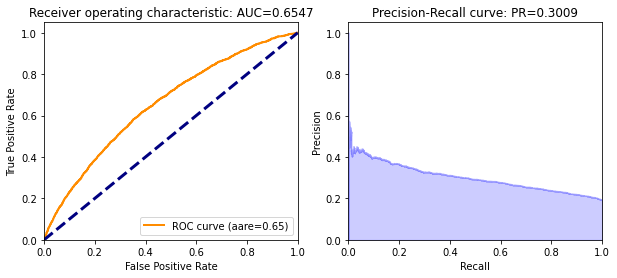

In [57]:
ROC_AUC(dl_fit2,test_dl,'loan_default')

The AUC increases to 0.6547 after setting the epoches.

#### Train a DL with early stopping
Using the same model parameters as dl_fit2, we will turn on early stopping and specify the stopping criterion. We will also pass a validation set, as is recommended for early stopping.

In [58]:
dl_fit3 = H2ODeepLearningEstimator(model_id='dl_fit3', 
                                   epochs=20, 
                                   hidden=[10,10],
                                   score_interval=1,          #used for early stopping
                                   stopping_rounds=3,         #used for early stopping
                                   stopping_metric='AUC',     #used for early stopping
                                   stopping_tolerance=0.0005, #used for early stopping
                                   seed=1)
dl_fit3.train(x=predictors_new, y=target, training_frame=train_dl, validation_frame=valid_dl)

deeplearning Model Build progress: |

C:\ProgramData\Anaconda3\envs\gpu2\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [CR012, AP005_year, TD029, TD028, TD027, TD026, TD025]
  warnings.warn(mesg["message"], RuntimeWarning)


█████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: dl_fit3


Status of Neuron Layers: predicting loan_default, 2-class classification, bernoulli distribution, CrossEntropy loss, 732 weights/biases, 19.7 KB, 960,000 training samples, mini-batch size 1
    layer    units    type       dropout    l1    l2    mean_rate             rate_rms               momentum    mean_weight           weight_rms           mean_bias               bias_rms
--  -------  -------  ---------  ---------  ----  ----  --------------------  ---------------------  ----------  --------------------  -------------------  ----------------------  -------------------
    1        59       Input      0.0
    2        10       Rectifier  0.0        0.0   0.0   0.14553798076887103   0.35929667949676514    0.0         0.003250138659742503  0.20244425535202026  0.4522326234139987      0.10663965344429016
    3        10       Rectifier  0.0        0.0   0.0   0.011627816462569171  0.024088509380817413   0.0         -0.10293973114341498  0.32456958293914795  0.8428186566742781      0.10852223634719849
    4        2        Softmax               0.0   0.0   0.001888443912321236  0.0009765205904841423  0.0         0.5940951053053141    1.5538873672485352   -0.0005891799324552749  0.0968329906463623

ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.14458477630867775
RMSE: 0.3802430489945579
LogLoss: 0.45654315454154776
Mean Per-Class Error: 0.36269825460662697
AUC: 0.6809940500051295
AUCPR: 0.3281696237679698
Gini: 0.36198810001025894

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20113653202642087
       0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      5015  3051  0.3783   (3051.0/8066.0)
1      662   1245  0.3471   (662.0/1907.0)
Total  5677  4296  0.3723   (3713.0/9973.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.201137     0.401419  219
max f2                       0.113162     0.564664  312
max f0point5                 0.275004     0.357381  150
max accuracy                 0.562551     0.809686  12
max precision                0.737921     1         0
max recall                   0.00734402   1         398
max specificity              0.737921     1         0
max absolute_mcc             0.253348     0.220123  169
max min_per_class_accuracy   0.205813     0.635029  214
max mean_per_class_accuracy  0.200118     0.637373  220
max tns                      0.737921     8066      0
max fns                      0.737921     1906      0
max fps                      0.00299705   8066      399
max tps                      0.00734402   1907      398
max tnr                      0.737921     1         0
max fnr                      0.737921     0.999476  0
max fpr                      0.00299705   1         399
max tpr                      0.00734402   1         398

Gains/Lift Table: Avg response rate: 19.12 %, avg score: 19.46 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100271                   0.455159           2.56254   2.56254            0.49             0.518412   0.49                        0.518412            0.0256948       0.0256948                  156.254   156.254            0.019372
2        0.0200541                   0.423209           2.14417   2.35336            0.41             0.4385     0.45                        0.478456            

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



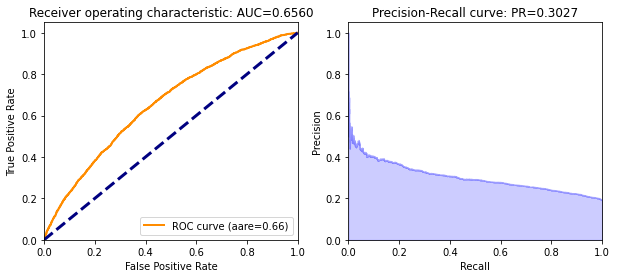

In [59]:
ROC_AUC(dl_fit3,test_dl,'loan_default')

Compare the model performance of the three models using a test set and AUC

In [69]:
dl_perf1 = dl_fit1.model_performance(test_dl)
dl_perf2 = dl_fit2.model_performance(test_dl)
dl_perf3 = dl_fit3.model_performance(test_dl)
# Retreive test set AUC
print(dl_perf1.auc())
print(dl_perf2.auc())
print(dl_perf3.auc())

0.6433773325712221
0.6546982825138022
0.6559677803446168


Based on the result of AUC, the third model with more epochs and early stopping reach 0.6560, which is better than the other two. The added hyper-parameters do improve the model performance.

### 5.3 Grid Search for hyper_parameter tuning
Next we will explore some deep learning parameters in a random grid search. We will execute the grid search for 120 seconds.
 - **Learning Rate (LR)**: If the learning rate (LR) is too small, overfitting can occur. Large learning rates help to regularize the training but if the learning rate is too large, the training will diverge. Hence a grid search of short runs to find learning rates that converge or diverge is possible but we have another approach called “Cyclical learning rates (CLR)” by Leslie N. Smith.
 - **Epochs**: An epoch is a term used in machine learning and indicates the number of passes of the entire training dataset the machine learning algorithm has completed. We can use 'epochs' methoid in h2o to specify the number of times to iterate (stream) the dataset. The value can be a fraction.
 - **Activation**:  In artificial neural networks, the activation function of a node defines the output of that node given an input or set of inputs. 
 - **l1**: Specify the L1 regularization to add stability and improve generalization; sets the value of many weights to 0 (default).
 - **l2**: Specify the L2 regularization to add stability and improve generalization; sets the value of many weights to smaller values. Defaults to 0.

In [94]:
# DL hyperparameters
activation_opt = ["Rectifier", "RectifierWithDropout", "Maxout", "MaxoutWithDropout"] 
epochs = [20, 40, 60]
learning_rate =[0.1, 0.01, 0.001]
l1_opt = [0, 0.00001, 0.0001, 0.001, 0.01, 0.1]
l2_opt = [0, 0.00001, 0.0001, 0.001, 0.01, 0.1]
dl_params = {'activation': activation_opt, 
             'epochs': epochs, 
             'adaptive_rate': learning_rate, 
             'l1': l1_opt, 
             'l2': l2_opt}

# Search criteria
search_criteria = {'strategy': 'RandomDiscrete', 'max_runtime_secs': 120, 'seed':1}
#search_criteria = {'strategy': 'RandomDiscrete', 'max_models': 36, 'seed': 1}

In [95]:
dl_grid = H2OGridSearch(model=H2ODeepLearningEstimator,
                        grid_id='dl_grid',
                        hyper_params=dl_params,
                        search_criteria=search_criteria)
dl_grid.train(x=predictors_new, y=target,
              training_frame=train_dl, 
              validation_frame=valid_dl, 
              hidden=[10,10])

deeplearning Grid Build progress: |██████████████████████████████████████████████| (done) 100%


,activation,adaptive_rate,epochs,model_ids,logloss
,Maxout,0.0,60.0,dl_grid_model_123,0.4616649
,Maxout,0.0,40.0,dl_grid_model_41,0.4620759
,Maxout,0.0,40.0,dl_grid_model_33,0.4620793
,Rectifier,0.0,60.0,dl_grid_model_43,0.4621585
,Maxout,0.0,40.0,dl_grid_model_45,0.4622017
,MaxoutWithDropout,0.0,20.0,dl_grid_model_40,0.4624650
,Maxout,0.0,20.0,dl_grid_model_106,0.4624805
,Rectifier,0.0,20.0,dl_grid_model_60,0.4625069
,MaxoutWithDropout,0.0,60.0,dl_grid_model_7,0.4625407
,RectifierWithDropout,0.0,60.0,dl_grid_model_49,0.4625789


In [96]:
dl_gridperf = dl_grid.get_grid(sort_by='auc', decreasing=True)

In [97]:
# Grab the model_id for the top GBM model, chosen by validation AUC
best_dl_model = dl_gridperf.models[0]

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



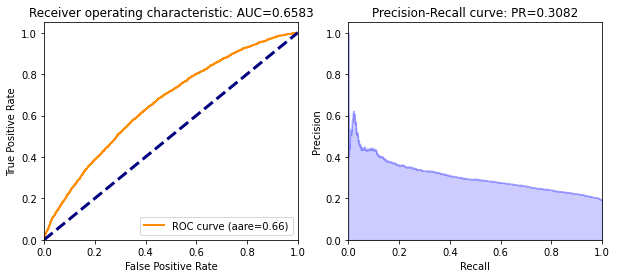

In [98]:
ROC_AUC(best_dl_model,test_dl,'loan_default')

According to the graph above, we were able to get the AUC on a holdout test set from 65.60% range with the default model to 65.84% range after tuning.

## 6. Conclusion <a class="anchor" id="6"></a>
In this report, we use GLM and DeepLearning to train machine learning models on the mortgage probability of default data.  

We first train a GLM model and then tune the hyper-parameters with grid search. The best model use a learn rate of 0.03, max_depth values of 4 and 300 trees, and reach a AUC of 0.6681. That means there is a **66.81%** chance that the model will be able to distinguish between loan default class and the normal class.  

We then splited the data in train, validation and test set and trained a predictive model using deep learning model from H2O, starting with a simple model, following with simple parameter tuning and then we used GridSearch to find the best parameters for the model, looking to maximize the AUC score for the validation set. The best model achieves an AUC score for the test data was **0.658**. That is to say, there is a **65.83%** chance that the model will be able to distinguish between loan default class and the normal class.

#### Reference:
 - https://github.com/h2oai/h2o-3/blob/master/h2o-docs/src/product/tutorials/gbm/gbmTuning.ipynb
 - https://github.com/h2oai/h2o-tutorials/blob/master/h2o-open-tour-2016/chicago/intro-to-h2o.ipynb
 - https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/deep-learning.html

#### [Back to the top](#0)